# Image segmentation

The task is to train a simple deep learning model to segment the cells visible in wide fluorescence images. \
I have decided to use an ordinary U-Net architecture for this purpose

I used the following libraries.

<b> tensorflow.keras </b> to implement the network, <b> os </b> and <b> matplotlib.image </b> to load the images, <b> numpy </b> and <b> skimage.transform </b> to transform the images and last but not least <b> matplotlib.pyplot </b> to plot my results.

In [15]:
import tensorflow.keras as tf_k                              
import os                                                     
import matplotlib.image as img                               
import numpy as np                                           
from skimage.transform import downscale_local_mean as dlm    
import matplotlib.pyplot as plt                              
%matplotlib inline  

## Task 1: Download the data
 
I downloaded the images and put them in folders right next to the Python program. \
The folders are called <b>'Masks'</b> and <b>'Images'</b>. 

```
/ 
+--Masks 
+--Images 
+--Image_Segmentation.ipynb
```

## Task 2: Analyzing and pre-processing

Each dataset consisted of wide-field epifluorescence images of cultured neurons with cytoplasmic (phalloidin) and nuclear staining (DAPI) and a series of manual segmentations of neuronal and nuclear boundaries.

```
One Set:
    1x image with cytoplasmic (phalloidin) staining    size: 1040x1392x1
    1x image with nuclear staining                     size: 1040x1392x1
    up too 3 masks                                     size:  520x 696x3
```


As far as I can tell, all the masks are segmented from the images with the cytoplasmic (phalloidin) channel. 

<table>
    <tr>
        <td><img src="https://cildata.crbs.ucsd.edu/display_images/ccdb/ccdb_512/6843_512r.jpg" width="300px"></td>
        <td><img src="https://cildata.crbs.ucsd.edu/display_images/ccdb/ccdb_512/6843_512s.jpg" width="300px"></td>
    </tr>
    <tr> 
        <td><i>Wide field fluorescent image of cultured neuroblastoma cells <br>
            labeled with phalloidn FITC (green) and DAPI (blue) nuclear stain.</i></td>
        <td><i>Manual segmentation of cell and nuclear <br>
            boundaries of double labeled cultured neurons.</i></td>
    </tr>
</table>

Therefore I decided to only use them to train my model. I load the other images as well since i want to see, how the model performs with them.

Also, only a few of the pictures have 3 corresponding masks and some only one. For this reason I only use one mask per image. \
So now I have 100 images and 100 masks.

The next step is to downsample the images and reshape the masks, so that they both have the same size of 520x696x1. \
This two task are done by the firs function. \
The function searches both folders, loads the images and reshapes the images and the masks.

In [16]:
def load_training_images(foldername_1='Masks', foldername_2='Images'):
    masks = []
    FITC_images = []
    DAPI_images = []
    
    for filename in os.listdir(foldername_1):
        if "GT_01" in filename:
            masks.append(  img.imread(  os.path.join(foldername_1, filename))[:,:,0]   )
        else:
            pass

    for filename in os.listdir(foldername_2):
        if "w1" in filename:
            FITC_images.append( dlm( img.imread(  os.path.join(foldername_2, filename)  ), (2,2) )  )
        if "w2" in filename:
            DAPI_images.append( dlm( img.imread(  os.path.join(foldername_2, filename)  ), (2,2) )  )
        else:
            pass
    return masks, FITC_images, DAPI_images


load_masks, load_FITC_images, load_DAPI_images = load_training_images()



The next function, normalizes the data by dividing all values by the highest value. \
I use the highest value of all the images, not just the current one.

In [17]:
def Normalize(Liste):
    max_value = np.max(Liste)
    for k in range(len(Liste)):
        Liste[k] = Liste[k]/max_value
    return Liste

norm_masks       = Normalize(load_masks)
norm_FITC_images = Normalize(load_FITC_images)
norm_DAPI_images = Normalize(load_DAPI_images)



The last step is to split the data into training and testing data and put it into the right shape one last time.
I use 60 images for training and 40 for testing.

I noticed that the images at the beginning contain more cells than the later images. Therefore, I take some pictures from the beginning and some from the end for training.

In [18]:
def get_data(masks, images_FITC, images_DAPI):
    
    masks = np.array(masks).reshape(100,520,696,1)
    
    images_FITC = np.array(images_FITC).reshape(100,520,696,1)
    
    masks_train       = np.vstack((masks[:30],masks[70:100]))
        
    images_FITC_train = np.vstack((images_FITC[:30],images_FITC[70:100]))
    
    masks_test        = masks[30:70]
    images_FITC_test  = images_FITC[30:70]
    
    images_DAPI = np.array(images_DAPI).reshape(100,520,696,1)
    
    return masks_train, images_FITC_train, masks_test, images_FITC_test, images_DAPI


y_train, x_train, y_test, x_test, x2_test = get_data(norm_masks, norm_FITC_images, norm_DAPI_images)

## Task 3: The model

The architecture I am using is a normal <b>U-Net architecture</b>. I ended up using only two <b>channel sizes, 8 and 16</b>, because I was getting performance problems when I ran the program.

The shape of the data goes from <b>520x696x1</b> to <b>260x348x8</b> to <b>130x174x16</b> and then back again.
 
For the Optemizer i chose the <b> Adam </b> algorithm and my loss-function is the <b> BinaryCrossentropy </b>, as I only have two classes which I want to differentiate. \
I also use a <b>dropout of 20%</b> to prevent overfitting.

In [19]:
def get_model(chanels=[8, 16], drop_rate=0.2):

    inputs = tf_k.Input(shape=(520,696,1))                                       

    c1 = tf_k.layers.Conv2D(chanels[0], 3, activation='relu', padding="same")(inputs)
    c1 = tf_k.layers.Dropout(drop_rate)(c1)
    c1 = tf_k.layers.Conv2D(chanels[0], 3, activation='relu', padding="same")(c1)

    p1 = tf_k.layers.MaxPool2D((2,2))(c1)                                        

    c2 = tf_k.layers.Conv2D(chanels[1], 3, activation='relu', padding="same")(p1)
    c2 = tf_k.layers.Dropout(drop_rate)(c2)
    c2 = tf_k.layers.Conv2D(chanels[1], 3, activation='relu', padding="same")(c2)  

    p2 = tf_k.layers.MaxPool2D((2,2))(c2)                                        

    c3 = tf_k.layers.Conv2D(chanels[1], 3, activation='relu', padding="same")(p2)
    c3 = tf_k.layers.Dropout(drop_rate)(c3)
    c3 = tf_k.layers.Conv2D(chanels[1], 3, activation='relu', padding="same")(c3)

    u1 = tf_k.layers.Conv2DTranspose(16, 2, strides=2, padding="same")(c3)
    u1 = tf_k.layers.concatenate([c2,u1])

    c4 = tf_k.layers.Conv2D(chanels[1], 3, activation='relu', padding="same")(u1)
    c4 = tf_k.layers.Dropout(drop_rate)(c4)
    c4 = tf_k.layers.Conv2D(chanels[1], 3, activation='relu', padding="same")(c4)

    u2 = tf_k.layers.Conv2DTranspose(chanels[0], 2, strides=2, padding="same")(c4)
    u2 = tf_k.layers.concatenate([c1,u2])

    c5 = tf_k.layers.Conv2D(chanels[0], 3, activation='relu', padding="same")(u2)
    c5 = tf_k.layers.Dropout(drop_rate)(c5)
    c5 = tf_k.layers.Conv2D(chanels[0], 3, activation='relu', padding="same")(c5)


    outputs = tf_k.layers.Conv2D(1, 1, activation='sigmoid', padding="same")(c5) 
    
    return tf_k.Model(inputs=inputs, outputs=outputs)






Fro the training i use 60 sets of images and masks, in batches of 5 at a time with 4 epochs.

In [20]:
my_model = get_model()
my_model.compile(optimizer="Adam", loss="BinaryCrossentropy", metrics=["accuracy"])
my_model.fit(x_train, y_train, epochs=4, batch_size=5)



Epoch 1/4
12/12 [==============================] - 40s 3s/step - loss: 0.6870 - accuracy: 0.7666
Epoch 2/4
12/12 [==============================] - 38s 3s/step - loss: 0.6510 - accuracy: 0.8698
Epoch 3/4
12/12 [==============================] - 38s 3s/step - loss: 0.6184 - accuracy: 0.9155
Epoch 4/4
12/12 [==============================] - 38s 3s/step - loss: 0.6018 - accuracy: 0.9268


For the testing i also use batches of 5, but this time only with 40 sets of images and masks.

In [21]:
my_model.evaluate(x_test, y_test, batch_size=5)

8/8 [==============================] - 5s 605ms/step - loss: 0.6069 - accuracy: 0.9462


[0.6069108843803406, 0.9462038278579712]

## Task 4: Results

After runing the model a few times, i got the folowing resaults.
<table>
    <tr><td></td><td><h4>average train</h4></td><td><h4>average test</h4></td>
        <td><h4>best train</h4></td><td><h4>best test</h4></td> </tr>
    <tr><td><h4>loss</h4></td><td><h4>0.37</h4></td><td><h4>0.18</h4></td>
        <td><h4>0.2455</h4> </td><td><h4>0.069</h4></td></tr>
    <tr><td><h4>accuracy</h4></td><td><h4>0.82</h4> </td><td><h4>0.9</h4></td>
        <td><h4>0.9268</h4></td><td><h4>0.975</h4></td></tr>
</table>

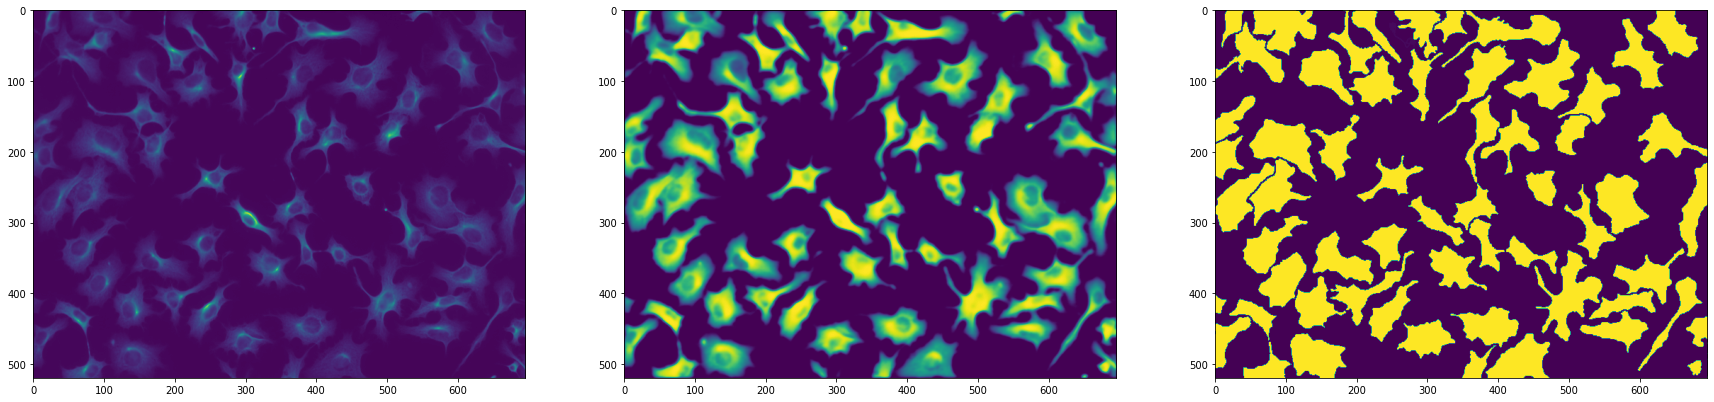

In [22]:
fig, ax = plt.subplots(1,3, figsize=(30,20))
ax[0].imshow(x_train[7])
ax[1].imshow(my_model(x_train[7:8])[0])
ax[2].imshow(y_train[7])

The plot above is a set of training data. On the left is the original image and on the right is the mask. in the middle is the prediction made by the model, which I thing is pretty good. It managed to identify all the cells and make them stand out from the background. \
On a positive note, the model is able to recognise cells that were omitted from the masks. You can see in the original and in the prediction that there is a cell at (150|150) that is missing in the mask. This also means that although I did not use all the masks to train the model, it still works . One downside to this is that the training and testing results are worse because the prediction does not match the masks perfectly. However, I would attribute this more to the faulty masks than to the model itself.





The same goes for the next graph below. All the cells have been clearly segmented.

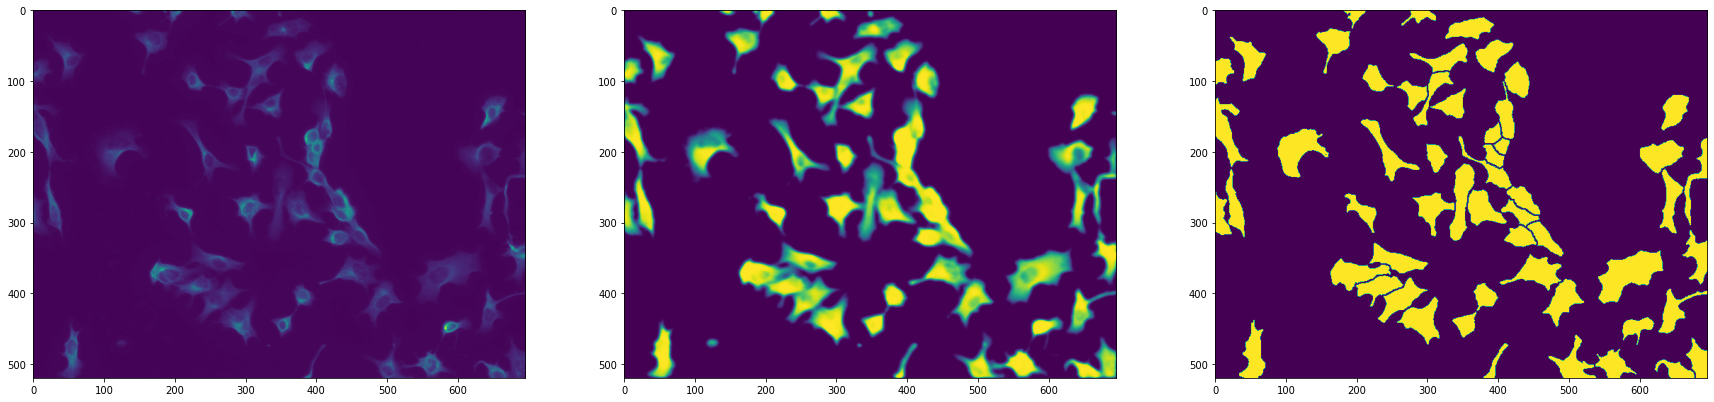

In [23]:
fig, ax = plt.subplots(1,3, figsize=(30,20))
ax[0].imshow(x_test[1])
ax[1].imshow(my_model(x_test[1:3])[0])
ax[2].imshow(y_test[1])

What the model does not do so well is to distinguish between cells that are touching. In the masks you can see a clear line between cells next to each other. My model could not do this. This may be because I didn't use enough convolution layers, or used layers that were too small. If i had started with a convolution with a channel size of 16, it would have found mor details. \
You can also see that the predictions are not nearly as fine as the masks. Compared to the masks, the edges of the predictions are round, without much detail.

What I found with the images with cytoplasmic (phalloidin) staining, also applies to the images with nuclear staining. The model was able to separate the cells from the background, but could not distinguish between adjacent cells. \
What i also found intresting, is that because the images with nuclear staining are not as blurred as the images with cytoplasmic (phalloidin) staining, the model had an easyer time working with them. But of course this is only speculation, since i don not have any corresponding masks for them to check this.

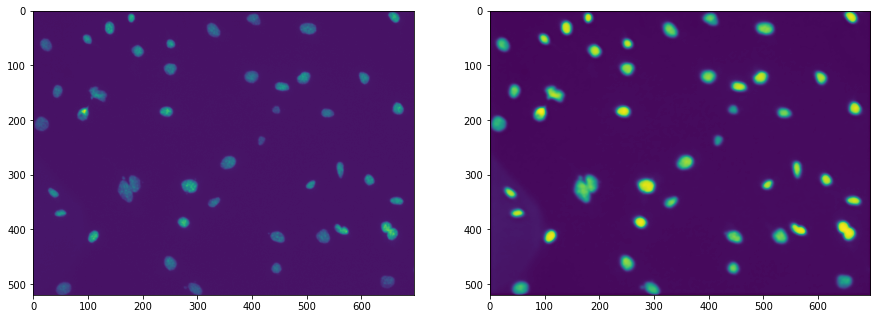

In [24]:
fig, ax = plt.subplots(1,2, figsize=(15,10))
ax[0].imshow(x2_test[27])
ax[1].imshow(my_model(x2_test[27:28])[0])

Another point that i noticed, was that in some images ther is somthing in de backround, which was pickt up by the model. This can be seen in the next plot, whitch is an image with nuclear staining. \
You can see in the plot below that there are some shapes in the background. They are visible in the original image and highlighted in the prediction. I do not know what this shapes are, if they are bigger cells or somthing else.

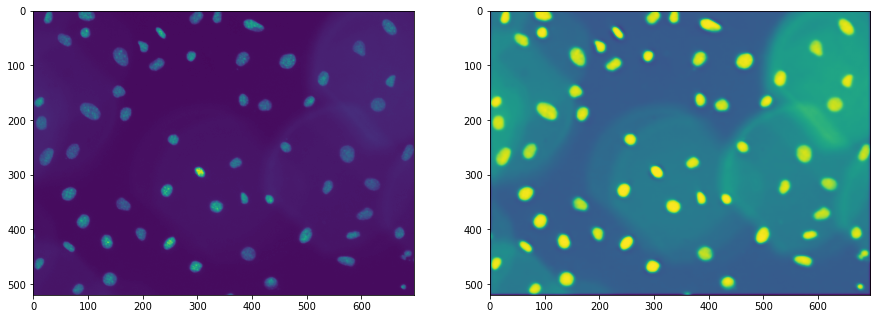

In [25]:
fig, ax = plt.subplots(1,2, figsize=(15,10))
ax[0].imshow(x2_test[7])
ax[1].imshow(my_model(x2_test[7:8])[0])

Sometimes the model seemed to pick up something in the picture that you couldn't see, as in the two plots below. In these cases I am not sure if there is something in the background that you simply cannot see with the naked eye, or if the model simply made a mistake. I only noticed this happening to images with nuclear staining and since i did not use them for training, it is to be expected that the model performs wors on them. Which leads me to believe that this is in fact a mistake made by the model.

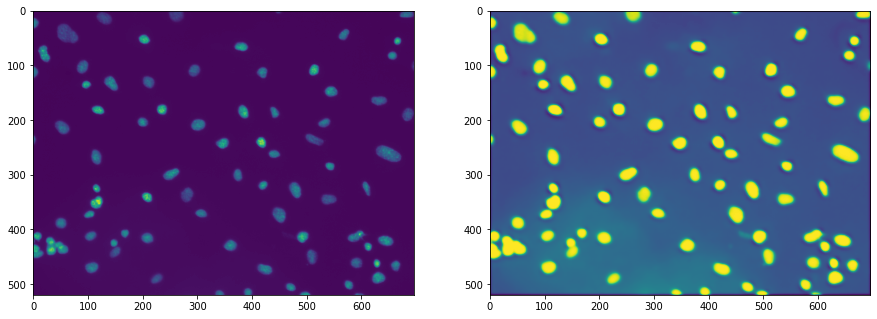

In [26]:
fig, ax = plt.subplots(1,2, figsize=(15,10))
ax[0].imshow(x2_test[2])
ax[1].imshow(my_model(x2_test[2:3])[0])

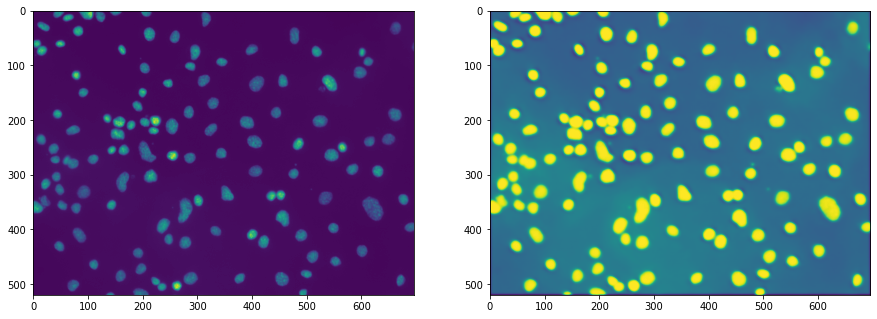

In [27]:
fig, ax = plt.subplots(1,2, figsize=(15,10))
ax[0].imshow(x2_test[6])
ax[1].imshow(my_model(x2_test[6:7])[0])

## Conclusion

In the end, I would say that the results are not perfect but satisfactory. Ther are defenetly a few things that could be done better, for example  increasing the dropout rate to reduce overfitting and thus improve performance on previously unseen data. To continue to achieve the same or even better accuracy, I would also increase the number of epochs that the model trains. \
If the edges of the cells in the predictions need to be as detailed as in the masks,  I would add more convolutional layers and increase their channel size.

All in all, I think the performance of the model is reasonably good considering its relatively small size, and if you want to increase the performance, you would also have to increase the size and complexity of the model.